In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

def load_data(path):
    df = pd.read_csv(path)
    train_df, test_df = train_test_split(df, test_size=0.35, random_state=42)
    train_df, val_df,  = train_test_split(train_df, test_size=0.20, random_state=42)
    train_df = train_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    test_df = test_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    val_df = val_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    return train_df, val_df, test_df

def encode_target(train):
    target_key = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4,'Obesity_Type_II' : 5, 'Obesity_Type_III': 6}
    train['NObeyesdad'] = train['NObeyesdad'].map(target_key)
    return train

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Male':0, 'Female':1})

def datatypes(train):
    train['Weight'] = train['Weight'].astype(float)
    train['Age'] = train['Age'].astype(float)
    train['Height'] = train['Height'].astype(float)
    return train

def age_binning(train_df):
    train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[0, 20, 30, 40, 50, train_df['Age'].max()], labels=['0-20', '21-30', '31-40', '41-50', '50+'])
    return train_df

def age_scaling_log(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    train_df['Log_Age'] = np.log1p(train_df['Age'])
    return train_df

def age_scaling_minmax(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    scaler_age = MinMaxScaler()
    train_df['Scaled_Age'] = scaler_age.fit_transform(train_df['Age'].values.reshape(-1, 1))
    return train_df, scaler_age

def weight_scaling_log(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    train_df['Log_Weight'] = np.log1p(train_df['Weight'])
    return train_df

def weight_scaling_minmax(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    scaler_weight = MinMaxScaler()
    train_df['Scaled_Weight'] = scaler_weight.fit_transform(train_df['Weight'].values.reshape(-1, 1))
    return train_df, scaler_weight

def height_scaling_log(train_df):
    train_df['Log_Height'] = np.log1p(train_df['Height'])
    return train_df

def height_scaling_minmax(train_df):
    scaler_height = MinMaxScaler()
    train_df['Scaled_Height'] = scaler_height.fit_transform(train_df['Height'].values.reshape(-1, 1))
    return train_df, scaler_height

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Female':1, 'Male':0})
    return train

def binary_columns(train):
    Binary_Cols = ['family_history_with_overweight','FAVC', 'SCC','SMOKE']
    # if yes then 1 else 0
    for col in Binary_Cols:
        train_df[col] = train_df[col].map({'yes': 1, 'no': 0})
    return train

def freq_cat_cols(train):
    # One hot encoding
    cat_cols = ['CAEC', 'CALC']
    for col in cat_cols:
        train[col] = train[col].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    return train

def Mtrans(train):
    """
    Public_Transportation    8692
    Automobile               1835
    Walking                   231
    Motorbike                  19
    Bike                       16
    """
    # train['MTRANS'] = train['MTRANS'].map({'Public_Transportation': 3, 'Automobile': 5, 'Walking': 1, 'Motorbike': 4, 'Bike': 2})
    # dummify column
    train = pd.get_dummies(train, columns=['MTRANS'])
    return train


def other_features(train):
    train['BMI'] = train['Weight'] / (train['Height'] ** 2)
    # train['Age'*'Gender'] = train['Age'] * train['Gender']
    polynomial_features = PolynomialFeatures(degree=2)
    X_poly = polynomial_features.fit_transform(train[['Age', 'BMI']])
    poly_features_df = pd.DataFrame(X_poly, columns=['Age^2', 'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'])
    train = pd.concat([train, poly_features_df], axis=1)
    return train


def test_pipeline(test, scaler_age, scaler_weight, scaler_height):
    test = datatypes(test)
    test = encode_target(test)
    test = age_binning(test)
    test = age_scaling_log(test)
    test['Scaled_Age'] = scaler_age.transform(test['Age'].values.reshape(-1, 1))
    test = weight_scaling_log(test)
    test['Scaled_Weight'] = scaler_weight.transform(test['Weight'].values.reshape(-1, 1))
    test = height_scaling_log(test)
    test['Scaled_Height'] = scaler_height.transform(test['Height'].values.reshape(-1, 1))
    test = make_gender_binary(test)
    test = binary_columns(test)
    test = freq_cat_cols(test)
    test = Mtrans(test)
    test = other_features(test)

    return test

path = '/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building/train.csv'
train_df, val_df, test_df = load_data(path)

train_df = datatypes(train_df)
train_df = encode_target(train_df)
train_df = age_binning(train_df)
train_df, scaler_age = age_scaling_minmax(train_df)
train_df = age_scaling_log(train_df)
train_df, scaler_weight = weight_scaling_minmax(train_df)
train_df = weight_scaling_log(train_df)
train_df, scaler_height = height_scaling_minmax(train_df)
train_df = height_scaling_log(train_df)
train_df = make_gender_binary(train_df)
train_df = binary_columns(train_df)
train_df = freq_cat_cols(train_df)
train_df = Mtrans(train_df)
train_df = other_features(train_df)

val = test_pipeline(test_df, scaler_age, scaler_weight, scaler_height)
test = test_pipeline(test_df, scaler_age, scaler_weight, scaler_height)




In [122]:
# datatypes of train_df
val_df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Accuracy: 1.0


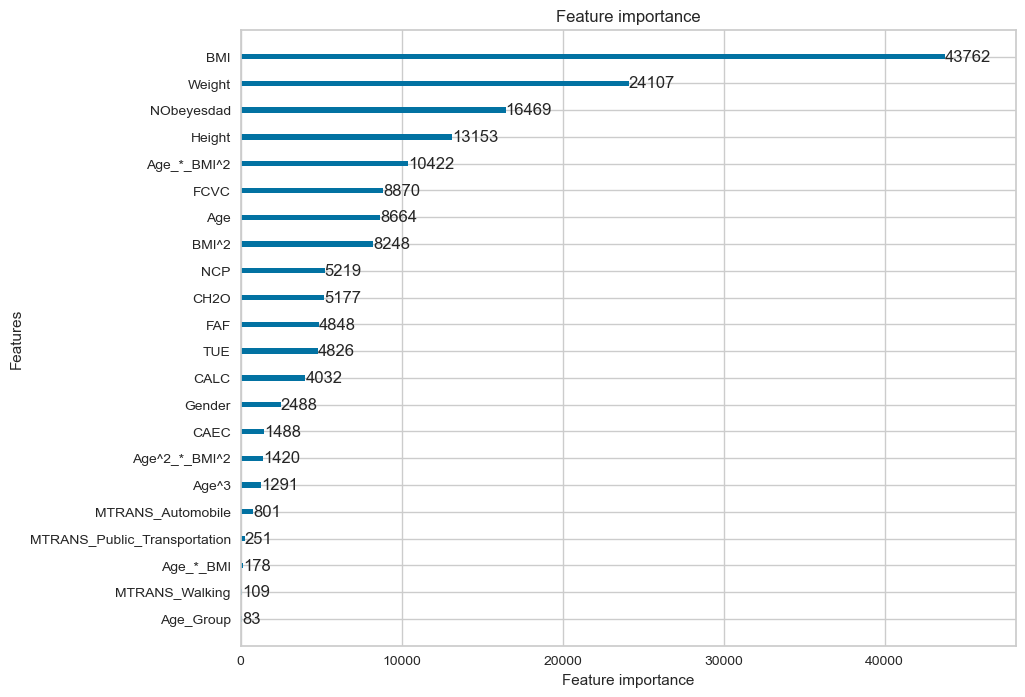

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: family_history_with_overweight: object, FAVC: object, SMOKE: object, SCC: object

In [118]:
Target = 'NObeyesdad'
features = train_df.columns.drop(Target)

features = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'NObeyesdad', 'Age_Group', 
       'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'Age^2',
       'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'] 
#'Scaled_Age', 'Log_Age', 'Scaled_Weight', 'Log_Weight', 'Scaled_Height', 'Log_Height',

X_train = train_df[features]
y_train = train_df[Target]

# combine df of X & y      
exp = pd.concat([X_train, y_train], axis=1)

# simple light gbm
import lightgbm as lgb
from sklearn.metrics import accuracy_score

lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'multiclass',
    'num_class': 7,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'verbosity': -1
}

model = lgb.train(params, lgb_train, num_boost_round=1000)
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred = [np.argmax(y) for y in y_pred]
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy}')

# feature importance
fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(model, ax=ax)
plt.show()


# Validation
X_val = val[features]
y_val = val[Target]
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_pred = [np.argmax(y) for y in y_pred]
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

In [71]:
y_val

0          Obesity_Type_III
1        Overweight_Level_I
2            Obesity_Type_I
3           Obesity_Type_II
4       Insufficient_Weight
               ...         
7261        Obesity_Type_II
7262          Normal_Weight
7263    Overweight_Level_II
7264       Obesity_Type_III
7265        Obesity_Type_II
Name: NObeyesdad, Length: 7266, dtype: object

In [70]:
y_pred

[6,
 2,
 4,
 5,
 1,
 0,
 6,
 5,
 6,
 3,
 0,
 0,
 5,
 0,
 3,
 2,
 2,
 2,
 3,
 1,
 5,
 4,
 2,
 5,
 3,
 0,
 5,
 0,
 1,
 1,
 1,
 3,
 0,
 6,
 4,
 5,
 5,
 0,
 4,
 6,
 6,
 5,
 5,
 5,
 5,
 4,
 6,
 0,
 5,
 3,
 1,
 4,
 6,
 5,
 6,
 6,
 4,
 6,
 5,
 2,
 6,
 0,
 1,
 5,
 3,
 6,
 6,
 2,
 5,
 5,
 5,
 0,
 5,
 5,
 6,
 1,
 2,
 1,
 4,
 4,
 4,
 5,
 6,
 4,
 1,
 5,
 3,
 0,
 2,
 1,
 2,
 6,
 0,
 6,
 2,
 5,
 5,
 6,
 6,
 6,
 4,
 6,
 4,
 1,
 3,
 1,
 6,
 1,
 2,
 4,
 0,
 6,
 5,
 6,
 6,
 2,
 3,
 6,
 6,
 6,
 0,
 4,
 4,
 5,
 4,
 0,
 3,
 0,
 5,
 6,
 2,
 5,
 3,
 0,
 2,
 1,
 2,
 3,
 1,
 5,
 1,
 0,
 3,
 1,
 6,
 4,
 3,
 5,
 5,
 5,
 2,
 4,
 1,
 0,
 6,
 5,
 6,
 3,
 5,
 3,
 0,
 1,
 1,
 5,
 0,
 5,
 4,
 6,
 1,
 6,
 0,
 1,
 5,
 3,
 3,
 5,
 3,
 1,
 4,
 1,
 1,
 4,
 4,
 5,
 4,
 5,
 5,
 3,
 2,
 4,
 3,
 0,
 2,
 2,
 5,
 1,
 3,
 5,
 2,
 6,
 4,
 4,
 0,
 2,
 5,
 6,
 2,
 2,
 6,
 2,
 5,
 5,
 3,
 1,
 6,
 1,
 1,
 4,
 6,
 1,
 5,
 5,
 5,
 2,
 2,
 5,
 2,
 6,
 6,
 1,
 6,
 1,
 6,
 6,
 6,
 0,
 6,
 1,
 6,
 1,
 6,
 1,
 1,
 6,
 1,
 6,
 1,
 1,
 6,
 0,
